# Anomaly Detection of Congress Stock Investments

**Objective:** Identify anomalous trades in Congress stock data that may indicate insider trading

**Author:** Tiffany Chu

**Date:** Apr 4, 2024

In [1]:
#importing preprocessing/visualization libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

The dataset consists of combined data from Senate stock transactions, stock news events, and S&P performance metrics. It covers the period from 2020 to 2023 and contains approximately 30,000 rows and 30 relevant columns.

#### Data Dictionary

**Here is some information about the columns in the US congress trades dataset:**
- transaction_date: Date of the transaction.
- owner: Owner of the asset (e.g., Senator, Spouse).
- ticker: Ticker symbol of the asset.
- asset_description: Description of the asset (e.g., company name, stock type).
- asset_type: Type of asset (e.g., Stock, Bond, Real Estate).
- type: Type of transaction (e.g., Sale (Full), Purchase, Exchange).
- amount: Amount of the transaction in USD.
- comment: Additional comments or remarks related to the transaction.
- party: Political party affiliation of the Senator.
- state: State represented by the Senator.
- industry: Industry classification of the asset.
- sector: Sector classification of the asset.
- senator: Name of the Senator associated with the transaction.
- ptr_link: URL link to the Public Financial Disclosure Report (PTR) on the Senate's website.
- disclosure_date: Date when the transaction was disclosed.


## Table of Contents

1. Wrangle, process & clean the data
    - preprocess and combine house.csv and senate.csv
    - preprocess stock news dataset
2. EDA - Exploratory Data Analysis
    - summary statistics
    - Feature Engineering
    - plots for time series
    - Merge dataset with stock data metrics
    - Scaling
    - One hot encoding
3. Modelling using 2 algorithms to classify data, and calculate their performance
    - Clustering
    - AutoEncoders
4. Combining the results of both models into a new dataset for anomalous rows
5. Visualizations, interpreting model, plotting and deriving insights

## 1. Wrangle, process & clean the data
### Combining senate and house datasets 
- to get all congress stock news in one dataset

In [2]:
raw_data = pd.read_csv(r"C:\Users\Tiffany\desktop\1sprint\house.csv")
raw_data2 = pd.read_csv(r"C:\Users\Tiffany\desktop\1sprint\senate.csv")

raw_data.head() #look at dataset

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Real Estate,Republican
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Farming/Seeds/Milling,Consumer Non-Durables,Republican
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,CA,https://disclosures-clerk.house.gov/public_dis...,False,Investment Bankers/Brokers/Service,Finance,Democrat


#### Combining Senate and House of Commons dataset

Steps:
- First loading the data 
- then changing column names from 'representative' or 'senator' to 'name' so they can be in the same column, since both are in the category of Congress
- next keeping only relevant columns that both have in common
- then reordering the columns so that both datasets have the same column order
- lastly, merging on the specified columns

In [3]:
raw_data = pd.read_csv(r"C:\Users\Tiffany\desktop\1sprint\house.csv")
raw_data2 = pd.read_csv(r"C:\Users\Tiffany\desktop\1sprint\senate.csv")

#change column names from 'representative' or 'senator' to 'name' so they can be in the same column. Both in the category of Congress
raw_data2.rename(columns={'senator': 'name'}, inplace=True)
raw_data.rename(columns={'representative': 'name'}, inplace=True)

raw_data = raw_data[['transaction_date', 'owner', 'ticker', 'asset_description', 'type', 'amount', 'party', 'state', 'industry', 'sector', 'ptr_link', 'disclosure_date', 'name']]
raw_data2 = raw_data[['transaction_date', 'owner', 'ticker', 'asset_description', 'type', 'amount', 'party', 'state', 'industry', 'sector', 'ptr_link', 'disclosure_date', 'name']]

raw_data2 = raw_data2.reindex(columns=raw_data.columns)

In [4]:
raw_data = pd.merge(raw_data, raw_data2, on=['transaction_date', 'owner', 'ticker', 'asset_description', 'type', 'amount', 'party', 'state', 'industry', 'sector', 'ptr_link', 'disclosure_date', 'name'], how='inner')
raw_data.head()

,transaction_date,owner,ticker,asset_description,type,amount,party,state,industry,sector,ptr_link,disclosure_date,name
0,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Republican,NC,Integrated oil Companies,Energy,https://disclosures-clerk.house.gov/public_dis...,10/04/2021,Virginia Foxx
1,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Republican,NC,Integrated oil Companies,Energy,https://disclosures-clerk.house.gov/public_dis...,10/04/2021,Virginia Foxx
2,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Republican,NC,Real Estate Investment Trusts,Real Estate,https://disclosures-clerk.house.gov/public_dis...,10/04/2021,Virginia Foxx
3,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Republican,NC,Farming/Seeds/Milling,Consumer Non-Durables,https://disclosures-clerk.house.gov/public_dis...,10/04/2021,Virginia Foxx
4,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Democrat,CA,Investment Bankers/Brokers/Service,Finance,https://disclosures-clerk.house.gov/public_dis...,10/04/2021,Alan S. Lowenthal


##### changing columns to their right format

In [5]:
#change date disclosure and transaction column to yyyy-mm-dd
raw_data['disclosure_date'] = pd.to_datetime(raw_data['disclosure_date'], errors='coerce')
raw_data['transaction_date'] = pd.to_datetime(raw_data['transaction_date'], errors='coerce')

In [6]:
raw_data.shape

(18774, 13)

In [7]:
raw_data.info() #checking datatypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18774 entries, 0 to 18773
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   18762 non-null  datetime64[ns]
 1   owner              11612 non-null  object        
 2   ticker             18774 non-null  object        
 3   asset_description  18770 non-null  object        
 4   type               18774 non-null  object        
 5   amount             18774 non-null  object        
 6   party              18675 non-null  object        
 7   state              18774 non-null  object        
 8   industry           13815 non-null  object        
 9   sector             13815 non-null  object        
 10  ptr_link           18774 non-null  object        
 11  disclosure_date    18774 non-null  datetime64[ns]
 12  name               18774 non-null  object        
dtypes: datetime64[ns](2), object(11)
memory usage: 1.9+ MB


In [8]:
(raw_data.isna().mean() * 100).round(2) #checking percentages of columns that contain nulls

transaction_date      0.06
owner                38.15
ticker                0.00
asset_description     0.02
type                  0.00
amount                0.00
party                 0.53
state                 0.00
industry             26.41
sector               26.41
ptr_link              0.00
disclosure_date       0.00
name                  0.00
dtype: float64

In [9]:
raw_data.isna().sum() # checking total sum of nulls in that column

transaction_date       12
owner                7162
ticker                  0
asset_description       4
type                    0
amount                  0
party                  99
state                   0
industry             4959
sector               4959
ptr_link                0
disclosure_date         0
name                    0
dtype: int64

##### Summary of Missing Values
Having nulls in owner, industry, and sector is alright, as it is not required for this to be included, oftentimes if it is empty, that insinuates it is owned by oneself. However, the missing transaction date, asset description, and party is unusual and there are unclear reasons for these missing values. 

I now investigate and fill in or delete rows with missing values

In [10]:
raw_data['owner'].value_counts() # to see category names in owner column

owner
joint        5867
self         3854
--           1343
dependent     548
Name: count, dtype: int64

In [11]:
nullrows = raw_data[raw_data[['industry', 'transaction_date']].isna().any(axis=1)]
print(nullrows)

      transaction_date  owner ticker  \
6           2021-11-30    NaN  KPLTW   
15          2021-10-07  joint   DUKH   
23          2022-09-08    NaN     --   
24          2022-09-08    NaN     --   
25          2022-09-14    NaN     --   
...                ...    ...    ...   
18721       2020-03-23  joint    UTX   
18730       2020-05-08  joint    CNI   
18734       2020-05-07  joint   CENT   
18741       2020-05-12  joint   GRUB   
18749       2020-05-11  joint  NSRGY   

                                       asset_description          type  \
6                        Katapult Holdings Inc - Warrant      purchase   
15     Duke Energy Corporation 5.125% Junior Subordin...     sale_full   
23                                   Harris County TX 5%     sale_full   
24                            Main Mun Bd BK 5% 09/01/27     sale_full   
25                               New York St 5% 06/15/27     sale_full   
...                                                  ...           ...   
1

**Since the transaction date must be at most 45 days before the disclosure date, we will assume this and input the 12 missing transaction dates with this**

In [12]:
#using the disclosure date column but with the date 45 days prior
raw_data['transaction_date'].fillna(raw_data['disclosure_date'] - pd.Timedelta(days=45), inplace=True)
print(raw_data['transaction_date'].isna().sum()) #check again, should be 0 after

0


In [13]:
#replace the null values in the 'owner' column with the string 'self' 
print(raw_data['owner'].isna().sum())
raw_data['owner'].fillna('self', inplace=True)
print(raw_data['owner'].isna().sum()) #check again, should be 0 after

7162
0


**Identifying party nulls and manually inputting**
- checked that the list of names where there is a missing party, has missing parties in ALL rows with that name, so the only choice is to manually input. Turns out theyre all democrats


In [14]:
rows_with_nulls = raw_data[raw_data['party'].isna()]
namelist = rows_with_nulls['name'].tolist()
pd.Series(namelist).value_counts()

Jared Moskowitz        35
Shri Thanedar          30
Jonathan Jackson       10
Max Miller              7
Morgan McGarvey         6
Eric Burlison           5
Ada Norah Henriquez     4
Jeff Jackson            2
Name: count, dtype: int64

In [15]:
raw_data['party'].fillna('Democrat', inplace=True) #replacing NaN with democrat
print(raw_data['party'].isna().sum()) #check again, should be 0 after

0


In [16]:
#replace the null values in the 'industry' column with the string 'na' 
print(raw_data['industry'].isna().sum())
raw_data['industry'].fillna('na', inplace=True)
print(raw_data['industry'].isna().sum()) #check again, should be 0 after

4959
0


In [17]:
#since the last 2 columns with missing values (industry and sector) are categories, change them to 'na'
raw_data.fillna('unknown', inplace=True)
print(raw_data.isna().sum()) #check again, should be 0 after

transaction_date     0
owner                0
ticker               0
asset_description    0
type                 0
amount               0
party                0
state                0
industry             0
sector               0
ptr_link             0
disclosure_date      0
name                 0
dtype: int64


In [18]:
raw_data.describe().T

,count,mean,min,25%,50%,75%,max
transaction_date,18774,2021-02-21 16:02:18.063279104,2012-06-19,2020-05-14,2021-01-15,2021-10-22,2023-12-22
disclosure_date,18774,2021-04-19 17:27:12.598274048,2020-01-02,2020-07-08,2021-03-03,2021-12-03,2023-05-14


## 2. EDA

party
Democrat       11474
Jackson           14
Libertarian        5
Republican      7281
dtype: int64

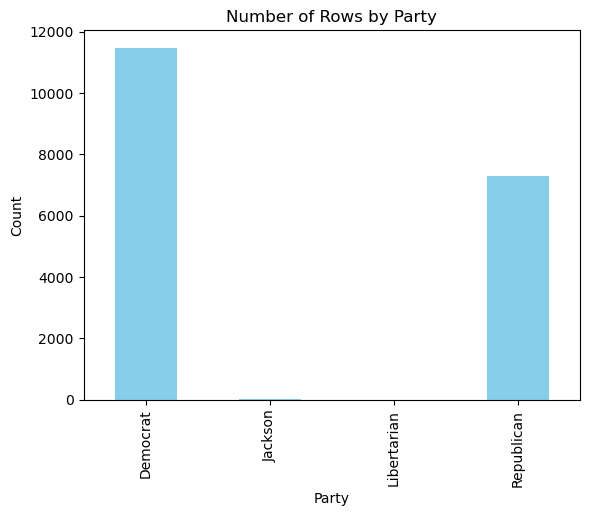

In [19]:
#bar chart showing the count of rows for each party after grouping
party_counts = raw_data.groupby('party').size()
party_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Rows by Party')
plt.xlabel('Party')
plt.ylabel('Count');

raw_data.groupby('party').size()

Text(0, 0.5, 'Count')

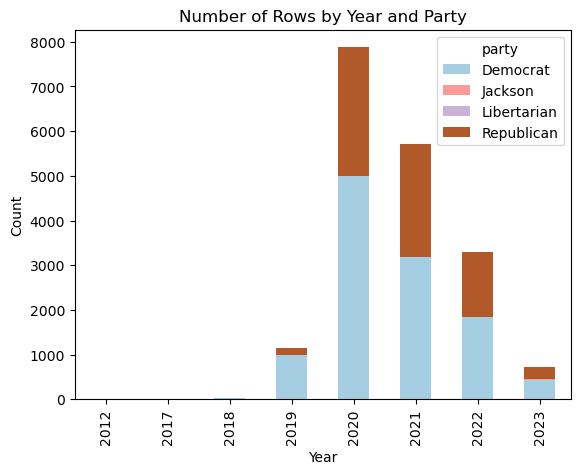

In [20]:
raw_data['year'] = raw_data['transaction_date'].dt.year

#bar chart showing the number of total transactions per year
grouped_data1 = raw_data.groupby(['year', 'party']).size().unstack()
grouped_data1.plot(kind='bar', stacked=True, colormap='Paired')
plt.title('Number of Rows by Year and Party')
plt.xlabel('Year')
plt.ylabel('Count')

sector
unknown                   4959
Technology                2913
Health Care               1807
Finance                   1527
Consumer Services         1416
Energy                     922
Public Utilities           905
Consumer Discretionary     839
Capital Goods              739
Industrials                590
Consumer Non-Durables      501
Miscellaneous              487
Basic Industries           340
Real Estate                250
Consumer Durables          198
Transportation             153
Utilities                  110
Consumer Staples            54
Telecommunications          35
Basic Materials             29
Name: count, dtype: int64

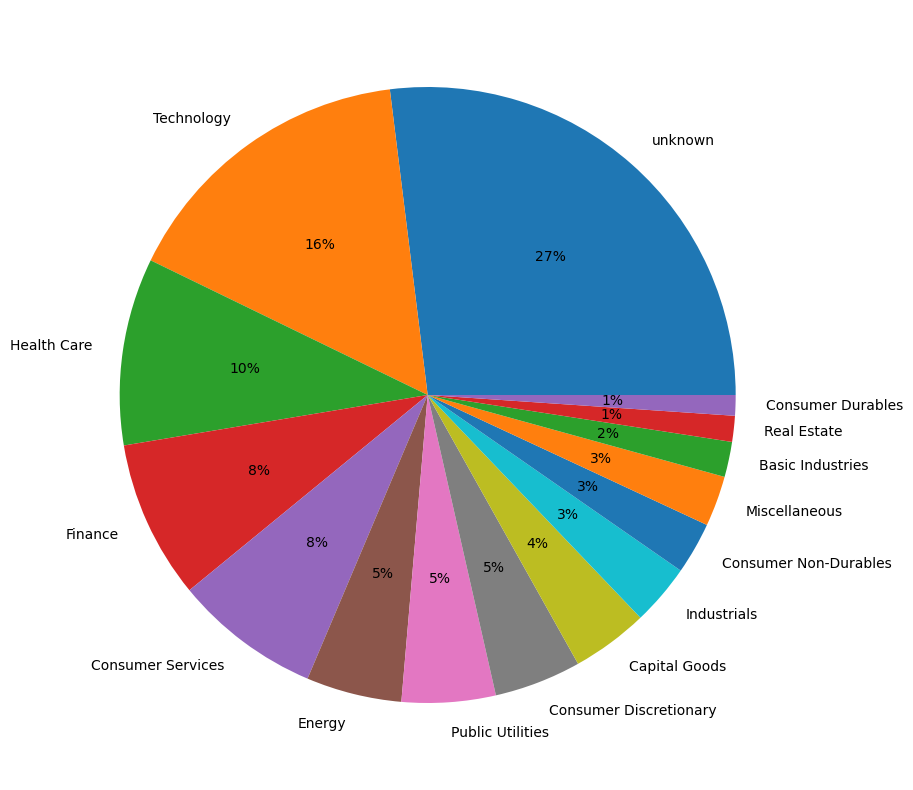

In [21]:
#pie chart showing the distribution of sectors in congress trades

sectorcounts = raw_data['sector'].value_counts()
percentages = sectorcounts / len(raw_data) * 100
sectorcounts1 = sectorcounts[percentages >= 1]
plt.figure(figsize=(10,10))  
plt.pie(sectorcounts1, labels=sectorcounts1.index, autopct='%1.f%%');

raw_data['sector'].value_counts()

In [23]:
raw_data['amount'].value_counts()
#it appears that most invest around 1k to 15k every transaction, however a few invest over 1000 in a single transaction

amount
$1,001 - $15,000            13064
$15,001 - $50,000            3010
$50,001 - $100,000            951
$100,001 - $250,000           717
$1,001 -                      391
$250,001 - $500,000           315
$500,001 - $1,000,000         199
$1,000,001 - $5,000,000        77
$1,000,000 +                   32
$5,000,001 - $25,000,000        9
$1,000 - $15,000                4
$15,000 - $50,000               3
$50,000,000 +                   1
$1,000,000 - $5,000,000         1
Name: count, dtype: int64

In [24]:
#feature engineering - 
#adding new column for upper bound to replicate amount but in a numerical format
raw_data['upper_bound'] = raw_data['amount'].str.split(' - ').str[-1]
#using regex 
raw_data['upper_bound'] = raw_data['upper_bound'].str.replace('[^\d]', '', regex=True).astype(float)
# values like $1,000,000 +  and $50,000,000 +   become NaNs, so change to their lower bound
raw_data['upper_bound'] = raw_data['upper_bound'].fillna(raw_data['amount'].str.split(' - ').str[0])
raw_data['upper_bound'].value_counts() #double checking


upper_bound
15000.0       13068
50000.0        3013
100000.0        951
250000.0        717
1001.0          391
500000.0        315
1000000.0       231
5000000.0        78
25000000.0        9
50000000.0        1
Name: count, dtype: int64

In [25]:
#filter data to include only amounts over $5,000,000
amt5mil = raw_data[raw_data['upper_bound'] > 500000]

#the representatives with amounts over $5,000,000
print(amt5mil[['upper_bound', 'name']].value_counts())

#amt5mil.groupby('name')['upper_bound'].sum().sort_values(ascending=False)

upper_bound  name                  
1000000.0    Suzan K. DelBene          45
             Scott H. Peters           41
             Nancy Pelosi              38
5000000.0    Josh Gottheimer           33
1000000.0    Mark E. Green             24
             Josh Gottheimer           22
5000000.0    Nancy Pelosi              19
1000000.0    Doris O. Matsui           13
             Michael T. McCaul          9
25000000.0   Suzan K. DelBene           6
5000000.0    Kevin Hern                 5
             Suzan K. DelBene           5
1000000.0    Kathy Manning              5
             Kevin Hern                 5
             Gilbert Cisneros           3
5000000.0    Scott Franklin             3
             Mark E. Green              3
1000000.0    Van Taylor                 3
             Trey Hollingsworth         3
5000000.0    Kim Schrier                2
1000000.0    Brad Sherman               2
             Kim Schrier                2
             Bradley S. Schneider       

In [26]:
raw_data.groupby('name')['upper_bound'].sum().sort_values(ascending=False).head(20)

name
Josh Gottheimer         300345000.0
Suzan K. DelBene        243325000.0
Nancy Pelosi            146432002.0
Kevin Hern              122795000.0
Mark E. Green           122430000.0
Scott H. Peters          63240000.0
Michael T. McCaul        48290000.0
Greg Gianforte           38400000.0
Donald S. Beyer, Jr.     29725000.0
Michael Waltz            26100000.0
K. Michael Conaway       21810000.0
Gilbert Cisneros         19675000.0
Virginia Foxx            19360000.0
Scott Franklin           19300000.0
Kim Schrier              18015000.0
Van Taylor               16210000.0
Kathy Manning            14990000.0
Doris O. Matsui          14865000.0
James R. Langevin        12840000.0
Alan S. Lowenthal        12162362.0
Name: upper_bound, dtype: float64

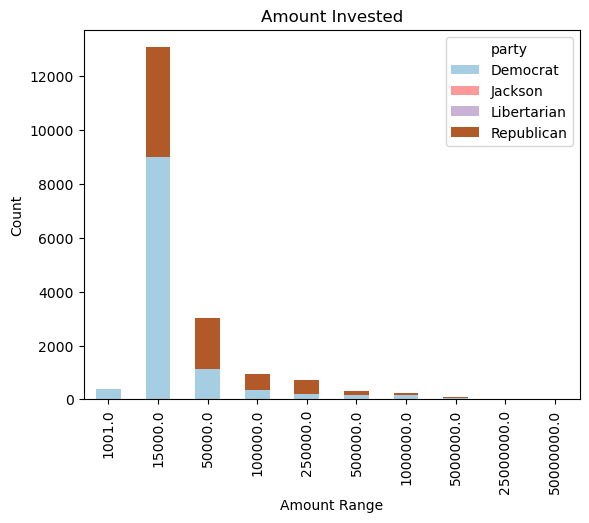

In [27]:
# a plot of amount bought or sold per transaction, split among parties

swag = raw_data.groupby(['upper_bound', 'party']).size().unstack()

#amt = raw_data['amount'].value_counts()
swag.plot(kind='bar', stacked=True, colormap='Paired')
plt.title('Amount Invested')
plt.xlabel('Amount Range')
plt.ylabel('Count')
plt.show()

### Adding S&P Stock Price based on transaction date
- (S&P) is a leading index provider and data source of independent credit ratings. The name comes from the merger of two financial data publications. For more than half a century, the S&P 500 has been an indicator for the performance of the stock market overall. Because it represents the largest publicly traded corporations in the US, its performance is seen as a snapshot of the state of US business, and by extension, the US economy. Here I use the S&P close price (adjusted), which is the final price at which the index traded on a particular trading day, after accounting for any corporate actions such as stock splits, dividends, or other adjustments that may affect the price -- a benchmark for evaluating the performance of top individual stocks

- Also adding the S&P volume, and unlike a market index (which suggests the market performance), the S&P 500 volume signifies the total number of shares of all securities traded on the S&P 500 index. It reflects the level of market activity -- higher volume indicates a higher number of traders that are interested in buying or selling, lower indicates a negative perception, it means that the price of a stock can decline shortly, and it can show a bearish pattern/ going down

In [28]:
!pip install yfinance

In [29]:
import yfinance as yf

In [30]:
sp = "^GSPC"  #ticker symbol for S&P 500
sp500_data = yf.download(sp, start="2017-01-01", end="2024-01-01")
data = raw_data[raw_data['transaction_date'].dt.year >= 2017]

[*********************100%%**********************]  1 of 1 completed


In [31]:
sp500_data #seeing the features included with this symbol

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000


In [32]:
# add/merge the S&P 500 data with the original dataset on the transaction date
data = pd.merge(raw_data, sp500_data[['Adj Close', 'Volume']], left_on='transaction_date', right_index=True, how='left')

#rename S&P data as a new column in raw_data
data.rename(columns={'Adj Close': 'SP500_Close'}, inplace=True)

#since data has unorganized dates in non-sequential rows, reorder it by sorting the
#dataset based on the date column
data.sort_values(by='transaction_date', inplace=True)

data.head()

,transaction_date,owner,ticker,asset_description,type,amount,party,state,industry,sector,ptr_link,disclosure_date,name,year,upper_bound,SP500_Close,Volume
12594,2012-06-19,self,BLFSD,BioLife Solutions Inc,purchase,"$1,001 - $15,000",Democrat,NJ,na,unknown,https://disclosures-clerk.house.gov/public_dis...,2021-08-26,Tom Malinowski,2012,15000.0,NaN,NaN
13574,2017-09-05,self,SUP,Superior Industries International Inc Common S...,purchase,"$1,001 - $15,000",Democrat,NY,Auto Parts:O.E.M.,Consumer Discretionary,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2017,15000.0,2457.850098,3.502190e+09
13555,2017-12-06,self,CAT,Caterpillar Inc,purchase,"$1,001 - $15,000",Democrat,NY,Construction/Ag Equipment/Trucks,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2017,15000.0,2629.270020,3.253080e+09
13554,2018-04-17,self,BA,Boeing Company,purchase,"$15,001 - $50,000",Democrat,NY,Aerospace,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2018,50000.0,2706.389893,3.286190e+09
13560,2018-04-30,self,CTRL,Control4 Corporation,purchase,"$1,001 - $15,000",Democrat,NY,na,unknown,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2018,15000.0,2648.050049,3.749510e+09


### Baseline time series analyses
analyzing how some of the numerical features look over time

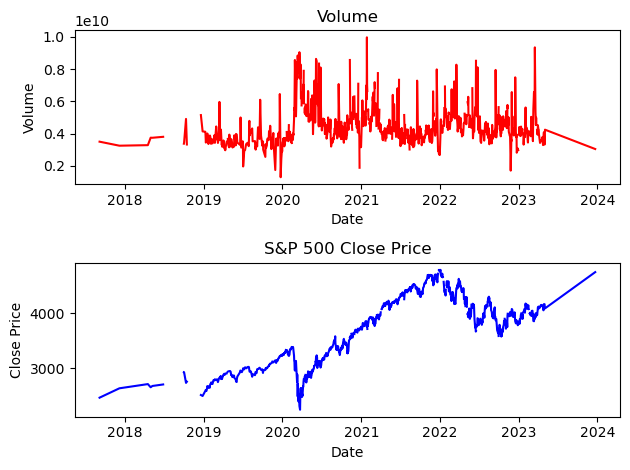

In [33]:
#since data has unorganized dates in non-sequential rows, reorder it by sorting the dataset based on the date column
data.sort_values(by='transaction_date', inplace=True)

#plot of: 

#S&P Volume plot
plt.subplot(2, 1, 1)
plt.plot(data['transaction_date'], data['Volume'], color='red', linestyle='-')
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')

#S&P 500 Close Price plot
plt.subplot(2, 1, 2)
plt.plot(data['transaction_date'], data['SP500_Close'], color='blue', linestyle='-')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()

##### EDA using a top earning congress member as an example
In the below blocks of code, I take an example senator and plot their investments into/out of the market over time, I also compare their investments the market. 

In [34]:
#using the Congress member: Nancy Pelosi

nancy_pelosi_data = data[data['name'] == 'Nancy Pelosi']

nancy_pelosi_data = nancy_pelosi_data[['transaction_date', 'upper_bound', 'type']]

nancy_pelosi_data.sort_values(by='transaction_date', inplace=True)

#make a column of 0s for net
nancy_pelosi_data['net'] = 0

#iterate over each row to update the 'net' column
net_sum = 0
for index, row in nancy_pelosi_data.iterrows():
    if row['type'] == 'purchase':
        net_sum += row['upper_bound']
    else:
        net_sum -= row['upper_bound']
    nancy_pelosi_data.at[index, 'net'] = net_sum

pd.DataFrame(nancy_pelosi_data) #turn into dataframe

,transaction_date,upper_bound,type,net
8236,2020-01-16,500000.0,purchase,500000
8234,2020-01-16,500000.0,sale_full,0
8235,2020-01-16,500000.0,purchase,500000
8233,2020-01-16,500000.0,sale_full,0
8232,2020-01-16,5000000.0,purchase,5000000
...,...,...,...,...
9057,2022-12-29,500000.0,sale_partial,35568999
9058,2022-12-30,500000.0,sale_partial,35068999
337,2023-01-20,1001.0,sale_full,35067998
7642,2023-03-09,1000000.0,purchase,36067998


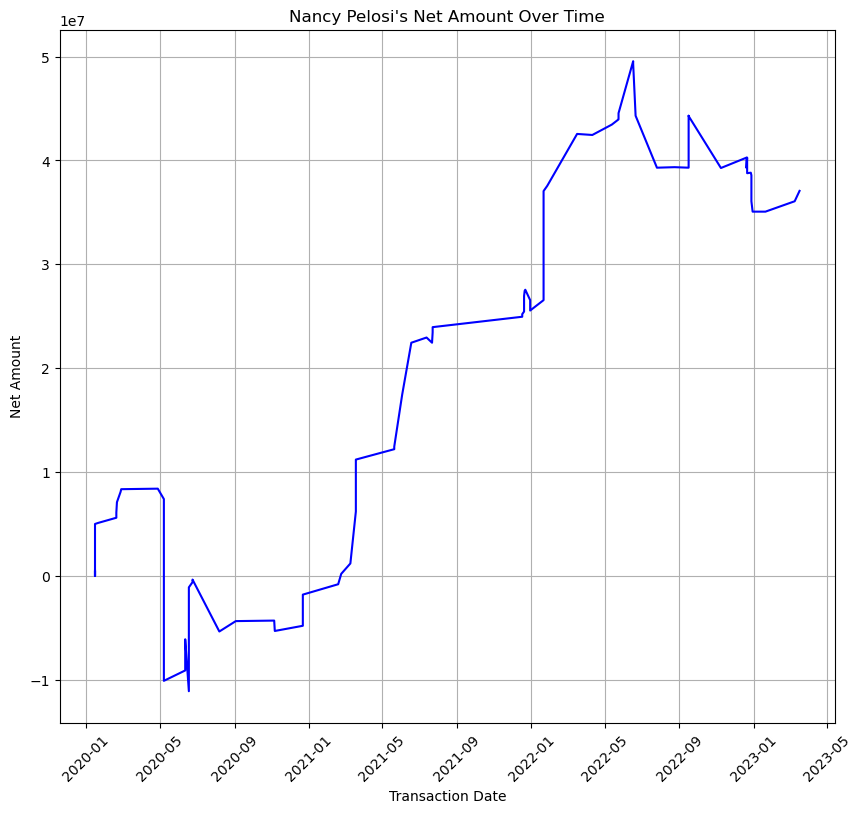

In [35]:
#plotting her net investments
plt.figure(figsize=(10, 9))
plt.plot(nancy_pelosi_data['transaction_date'], nancy_pelosi_data['net'], color='blue', linestyle='-')
plt.title("Nancy Pelosi's Net Amount Over Time")
plt.xlabel('Transaction Date')
plt.ylabel('Net Amount')
plt.grid(True)
plt.xticks(rotation=45);

Demonstrating how unscaled data looks. Pelosi's investments dominate other features in the data.

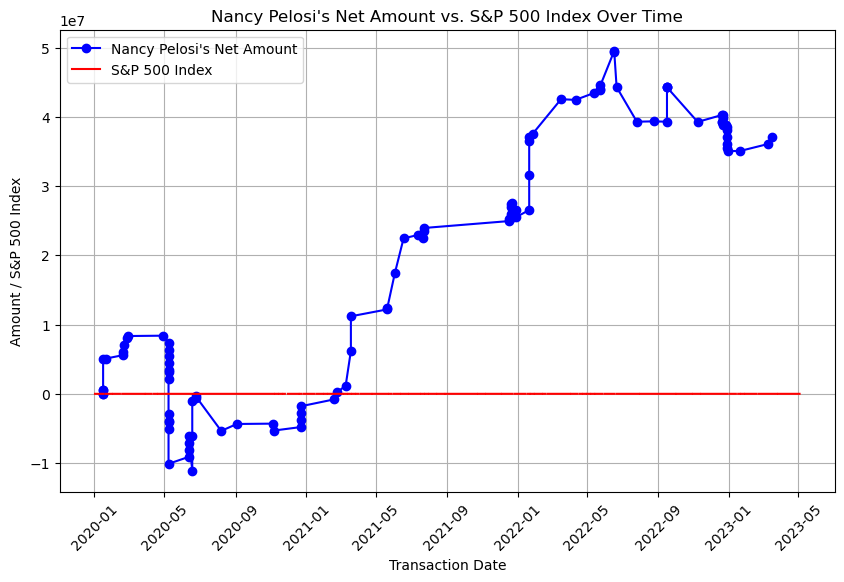

In [36]:
# pelosi's investments vs Market index Price

plt.figure(figsize=(10, 6))

#Nancy Pelosi's net amount over time
plt.plot(nancy_pelosi_data['transaction_date'], nancy_pelosi_data['net'], color='blue', marker='o', linestyle='-', label="Nancy Pelosi's Net Amount")

#filter S&P 500 data for the specified date range
sp500_filtered = data[(data['transaction_date'] >= '2020-01-01') & (data['transaction_date'] <= '2023-05-31')]

#plot sp500 too
plt.plot(sp500_filtered['transaction_date'], sp500_filtered['SP500_Close'], color='red', linestyle='-', label="S&P 500 Index")

plt.title("Nancy Pelosi's Net Amount vs. S&P 500 Index Over Time")
plt.xlabel('Transaction Date')
plt.ylabel('Amount / S&P 500 Index')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

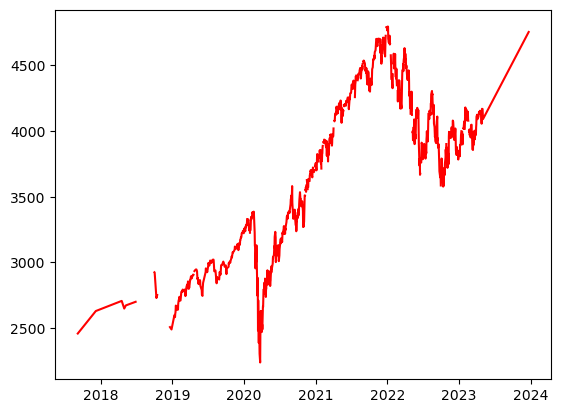

In [37]:
#this is how the S&P Index close price actually looks when not in comparison
plt.plot(data['transaction_date'], data['SP500_Close'], color='red', linestyle='-', label="S&P 500 Index")

similarly, adding a feature to the dataset that has the calculated net amount of each congress member over time (like what was done with Nancy Pelosi). Purchase adds to 'net' and sell subtracts from 'net'

In [38]:
grouped_data = data.groupby('name')
result_df = pd.DataFrame()

#iterate over each group (aka congress member)
for name, group in grouped_data:
    group.sort_values(by='transaction_date', inplace=True)
    # fill net with 0s
    group['net'] = 0
    #initialize net_sum
    net_sum = 0
    
    #update the 'net' column same as nancy pelosi
    for index, row in group.iterrows():
        if row['type'] == 'purchase':
            net_sum += row['upper_bound']
        else:
            net_sum -= row['upper_bound']
        group.at[index, 'net'] = net_sum
    
    result_df = pd.concat([result_df, group], ignore_index=True)

result_df.sort_values(by='transaction_date', inplace=True)
data = result_df
data.head()

,transaction_date,owner,ticker,asset_description,type,amount,party,state,industry,sector,ptr_link,disclosure_date,name,year,upper_bound,SP500_Close,Volume,net
17668,2012-06-19,self,BLFSD,BioLife Solutions Inc,purchase,"$1,001 - $15,000",Democrat,NJ,na,unknown,https://disclosures-clerk.house.gov/public_dis...,2021-08-26,Tom Malinowski,2012,15000.0,NaN,NaN,15000
17534,2017-09-05,self,SUP,Superior Industries International Inc Common S...,purchase,"$1,001 - $15,000",Democrat,NY,Auto Parts:O.E.M.,Consumer Discretionary,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2017,15000.0,2457.850098,3.502190e+09,15000
17535,2017-12-06,self,CAT,Caterpillar Inc,purchase,"$1,001 - $15,000",Democrat,NY,Construction/Ag Equipment/Trucks,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2017,15000.0,2629.270020,3.253080e+09,30000
17536,2018-04-17,self,BA,Boeing Company,purchase,"$15,001 - $50,000",Democrat,NY,Aerospace,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2018,50000.0,2706.389893,3.286190e+09,80000
17537,2018-04-30,self,CTRL,Control4 Corporation,purchase,"$1,001 - $15,000",Democrat,NY,na,unknown,https://disclosures-clerk.house.gov/public_dis...,2022-03-03,Thomas Suozzi,2018,15000.0,2648.050049,3.749510e+09,95000


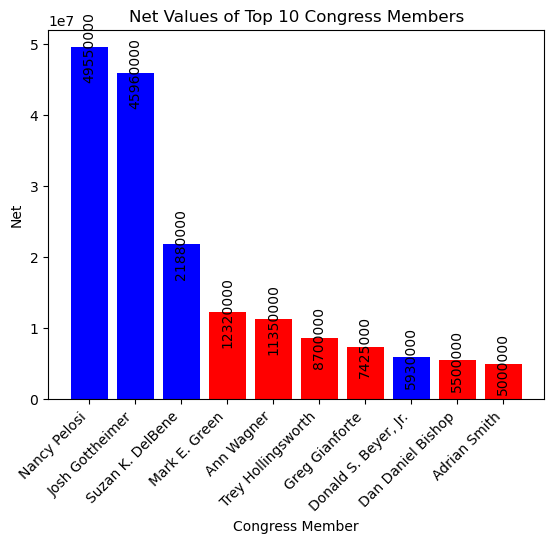

In [39]:
#extract the 10 congress members with the highest net
highest_net = data.sort_values(by='net', ascending=False)
top_net_names = highest_net['name'].unique()[:10]
top_net_values = highest_net[highest_net['name'].isin(top_net_names)].groupby('name')['net'].max().sort_values(ascending=False)

colors = {'Republican': 'red', 'Democrat': 'blue'}
party_colors = [colors[data[data['name'] == name]['party'].values[0]] for name in top_net_names]
plt.bar(top_net_names, top_net_values, color=party_colors)
plt.xlabel('Congress Member')
plt.ylabel('Net')
plt.title('Net Values of Top 10 Congress Members')
plt.xticks(rotation=45, ha='right')

for i in range(len(top_net_names)):
    plt.text(top_net_names[i], top_net_values[i], str(top_net_values[i]), ha='center', va='center', rotation=90)


In [40]:
result_df['transaction_unix_timestamp'] = result_df['transaction_date'].astype('int64') // 10**9
result_df['disclosure_unix_timestamp'] = result_df['disclosure_date'].astype('int64') // 10**9

In [41]:
col_drop = ['transaction_date', 'disclosure_date']
result_df = result_df.drop(columns=col_drop)
result_df.head()

,owner,ticker,asset_description,type,amount,party,state,industry,sector,ptr_link,name,year,upper_bound,SP500_Close,Volume,net,transaction_unix_timestamp,disclosure_unix_timestamp
17668,self,BLFSD,BioLife Solutions Inc,purchase,"$1,001 - $15,000",Democrat,NJ,na,unknown,https://disclosures-clerk.house.gov/public_dis...,Tom Malinowski,2012,15000.0,NaN,NaN,15000,1340064000,1629936000
17534,self,SUP,Superior Industries International Inc Common S...,purchase,"$1,001 - $15,000",Democrat,NY,Auto Parts:O.E.M.,Consumer Discretionary,https://disclosures-clerk.house.gov/public_dis...,Thomas Suozzi,2017,15000.0,2457.850098,3.502190e+09,15000,1504569600,1646265600
17535,self,CAT,Caterpillar Inc,purchase,"$1,001 - $15,000",Democrat,NY,Construction/Ag Equipment/Trucks,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,Thomas Suozzi,2017,15000.0,2629.270020,3.253080e+09,30000,1512518400,1646265600
17536,self,BA,Boeing Company,purchase,"$15,001 - $50,000",Democrat,NY,Aerospace,Capital Goods,https://disclosures-clerk.house.gov/public_dis...,Thomas Suozzi,2018,50000.0,2706.389893,3.286190e+09,80000,1523923200,1646265600
17537,self,CTRL,Control4 Corporation,purchase,"$1,001 - $15,000",Democrat,NY,na,unknown,https://disclosures-clerk.house.gov/public_dis...,Thomas Suozzi,2018,15000.0,2648.050049,3.749510e+09,95000,1525046400,1646265600


## Scaling data

Columns that need scaling are numerical features that are not binary or ordinal. In this dataset, the following columns:

- upper_bound: Amount of the transaction in USD
- SP500_close: The closing price of the market index
- Volume: Volume of trades for the day.

These columns contain numerical values that need to be scaled because it ensures that all features contribute equally to the analysis, and prevents features with larger scales from dominating the model. So, I use **Robust Scaling:**, It is suitable when dealing with datasets containing outliers, as it is less affected by them compared to Min-Max Scaling and Standardization, since its also ROBUST to outliers. 

I apply this scaling to the entire dataset (numerical columns) and plot some of the results below

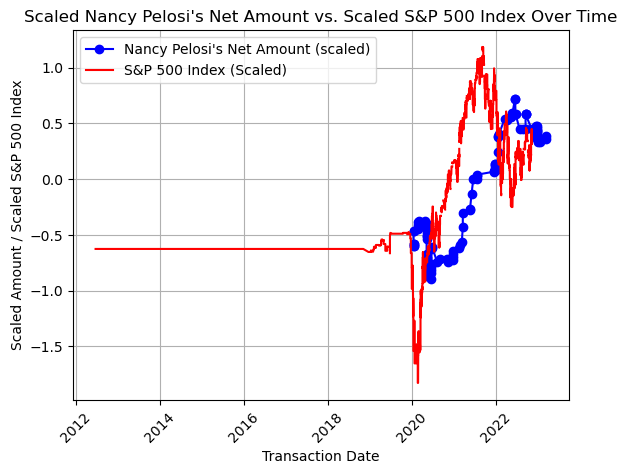

In [42]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

sp = sp500_filtered['SP500_Close'].values.reshape(-1, 1)
pelosi = nancy_pelosi_data['net'].values.reshape(-1, 1)

pelosi_scale = scaler.fit_transform(pelosi)
sp_scale = scaler.fit_transform(sp)

#plotting post-scaling so s&p isnt a flat line
plt.plot(nancy_pelosi_data['transaction_date'], pelosi_scale, color='blue', marker='o', linestyle='-', label="Nancy Pelosi's Net Amount (scaled)")
filtered_dates = data['transaction_date'].iloc[:len(sp_scale)]
plt.plot(filtered_dates, sp_scale, color='red', linestyle='-', label="S&P 500 Index (Scaled)")
plt.title("Scaled Nancy Pelosi's Net Amount vs. Scaled S&P 500 Index Over Time")
plt.xlabel('Transaction Date')
plt.ylabel('Scaled Amount / Scaled S&P 500 Index')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

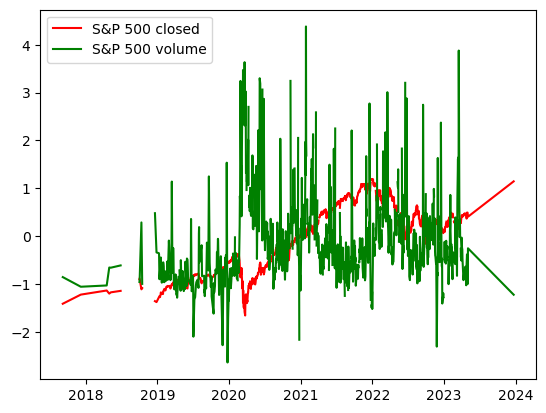

In [43]:
#also plotting the S&P price and volume after scaling
sp1 = data['SP500_Close'].values.reshape(-1, 1)
sp_scale1 = scaler.fit_transform(sp1)

vol1 = data['Volume'].values.reshape(-1, 1)
vol_scale1 = scaler.fit_transform(vol1)

plt.plot(data['transaction_date'], sp_scale1, color='red', linestyle='-', label="S&P 500 closed")
#plt.plot(data['transaction_date'], upper_bound_scale, color='blue', linestyle='-', label="S&P 500 closed")
plt.plot(data['transaction_date'], vol_scale1, color='green', linestyle='-', label="S&P 500 volume")
plt.legend()

## One Hot Encoding
type, party, industry, sector, owner -- are all categorical columns that can be turned into dummy variables for each category item

In [44]:
#scale numerical columns 
numerical_columns = ['year', 'upper_bound', 'SP500_Close', 'Volume', 'net', 'transaction_unix_timestamp', 'disclosure_unix_timestamp']

scaler = RobustScaler()
result_df[numerical_columns] = scaler.fit_transform(result_df[numerical_columns])

object_columns = ['owner', 'type', 'party', 'industry', 'sector', 'name']
data_dummies = pd.get_dummies(result_df, columns=object_columns)

col_drop = ['amount', 'state', 'ticker', 'asset_description', 'ptr_link', 'year']
data_dummies = data_dummies.drop(columns=col_drop)

In [45]:
#removing NaNs in columns, theres 2 rows
data_dummies = data_dummies.dropna().replace([np.inf, -np.inf], np.nan).dropna()

data_dummies.shape

(18667, 376)

In [46]:
booleans = data_dummies.select_dtypes(include=bool).columns
data_dummies[booleans] = data_dummies[booleans].astype(int)

In [47]:
data_dummies.head() #checking to see if scaling and one hot encoding worked as intended

,upper_bound,SP500_Close,Volume,net,transaction_unix_timestamp,disclosure_unix_timestamp,owner_--,owner_dependent,owner_joint,owner_self,...,name_Van Taylor,name_Vern Buchanan,name_Vicente Gonzalez,name_Victoria Spartz,name_Virginia Foxx,name_W. Gregory Steube,name_William R. Keating,name_William R. Timmons,name_Wm. Lacy Clay,name_Zoe Lofgren
17534,-0.100195,-1.956683,-1.020315,0.068212,-3.618599,0.97133,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17535,-0.100195,-1.673168,-1.208407,0.069868,-3.355567,0.97133,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17536,-0.052942,-1.545617,-1.183407,0.075389,-2.978174,0.97133,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17537,-0.100195,-1.642107,-0.833575,0.077045,-2.941006,0.97133,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17538,-0.100195,-1.602628,-0.836905,0.075389,-2.918134,0.97133,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 3. Modelling using Clustering and Autoencoders

### Clustering 
- hoping to find two clusters - anomaly and non-anomaly 
- then running an autoencorder to get anomaly-labelled ones
- finally comparing the two to see if the results are the same 

##### Agglomerative clustering 
A type of hierarchical clustering algorithm used for grouping similar objects into clusters, it can also determine distances between points and sub-clusters at multiple levels (other methods, K-Means, DBSCAN, and GMM did not yield clear results). 

- score is positive, which generally indicates that the clusters are well-separated
- but relatively close to 0, suggesting some degree of overlap between clusters or some points being close to the decision boundary
- Overall, a silhouette score of 0.182 indicates a reasonable level of separation between clusters

In [225]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

agglomerative_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward') #2 clusters one for anomaly and one for not

cluster_labels = agglomerative_clustering.fit_predict(data_dummies)

silhouette_avg = silhouette_score(data_dummies, cluster_labels)

silhouette_avg

#silhouette scores range from -1 to 1, so a positive score of 0.18 

0.1820026641426206

It appears below, that since the second cluster (1) is the less dense one, it is more likely to contain the outliers.  

Above I got the distance of the datapoints to their neighbouring data points in the cluster, and cluster 0 is more tightly centered/clustered, while cluster 1 is more spead out as the distances from their neighbouring point are larger - meaning it is more likely to be the anomaly cluster. I can also identify anomalous points in the data based on their silhouette scores being below a specified threshold value. These points are considered anomalies as they do not fit well within their assigned clusters according to the silhouette analysis, however, since there might be a pattern or cluster for anomalous rows, I decided to go with the former option. 


In [240]:
#getting the densities of the two clusters by measuring the distances of the points from each other 

from sklearn.neighbors import NearestNeighbors

cluster_densities = []
# Iterate over 2 cluster labels
for label in np.unique(cluster_labels):
    cluster_data = data_dummies.values[cluster_labels == label] # Using cluster_labels from above to define the two clusters
    nn_distances = NearestNeighbors(n_neighbors=2).fit(cluster_data).kneighbors()[1][:, 1]    #get nearest neighbor distances for clusters with more than one data point
    density = np.mean(nn_distances) #get density of each cluster then append
    cluster_densities.append(density)
print(f' cluster 0: {cluster_densities[0]} \n cluster 1: {cluster_densities[1]}')

#we can see that the second cluster has a total distance from the central point that is way larger, this larger value indicates that the points are distant and not dense, meaning they are likely outliers

 cluster 0: 3765.9162907933137 
 cluster 1: 5594.435259232636


**Dendrogram Cluster Viz**   
Identifying the smaller cluster and analyzing how dense it is can help show which one is the anomaly. Using the same method to calculate the distance between clusters, the linkage matrix is a function that provides information about how clusters are merged together during hierarchical clustering by making an array for:
-  index of the first cluster or data point being merged.
-  index of the second cluster or data point being merged.
-  distance or dissimilarity between the merged clusters (depending on the chosen method).

Interpreting the dendrogram: 
- longer vertical lines indicate a greater dissimilarity between the clusters

- it appears that the cluster on the right (1), is smaller, cannot tell how dense it is since the dataset is so large, but the distance (vertical lines) connecting the points are longer, meaning they are less dense

Text(0, 0.5, 'Distance (dissimilarity btwn data pts)')

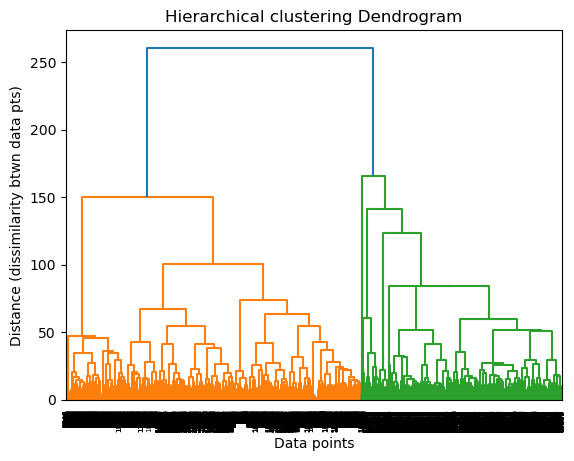

In [239]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute linkage matrix
linkage_matrix = linkage(data_dummies.values, method='ward') #function computes the linkage matrix, which is a two-dimensional array

dendrogram(linkage_matrix)
plt.title('Hierarchical clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance (dissimilarity btwn data pts)')

In [222]:
#since cluster label 1 has a sparser cluster, select the second (1) cluster an the anomalous one, make a dataset containing all the anomalous rows
anomalous_indices = np.where(cluster_labels == 1)[0] # 1 is the anomalous cluster label, use [0] to get index from array
anomalous_df = data_dummies.iloc[anomalous_indices]

#1232 out of 18667 rows were marked as anomalous, that's 6% of rows

,upper_bound,SP500_Close,Volume,net,transaction_unix_timestamp,disclosure_unix_timestamp,owner_--,owner_dependent,owner_joint,owner_self,...,name_Van Taylor,name_Vern Buchanan,name_Vicente Gonzalez,name_Victoria Spartz,name_Virginia Foxx,name_W. Gregory Steube,name_William R. Keating,name_William R. Timmons,name_Wm. Lacy Clay,name_Zoe Lofgren
3596,6.629919,-1.077060,-1.225592,0.618643,-1.414277,-1.450316,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11131,0.217072,-0.605676,-0.915333,-5.536022,-1.171259,0.310047,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14818,6.629919,-0.536029,-0.991329,0.618643,-1.151246,-1.327856,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11132,-0.100195,-0.567817,-0.646782,-5.534365,-1.096924,-1.220703,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11138,-0.100195,-0.431253,-1.082600,-5.524428,-1.068333,-1.220703,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,-0.052942,1.359881,2.586011,0.052754,1.113116,1.102975,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13872,0.554591,1.389701,0.100670,0.062691,1.167438,1.096852,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16168,-0.052942,0.812481,1.486809,0.074837,1.324685,1.252988,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16169,-0.100195,0.056126,2.768969,0.076493,1.373289,1.390756,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#merge the one-hot encoded df with the original df (result_df pre dummified) based on their indices
anomalous_df = result_df.iloc[anomalous_indices].merge(data_dummies.iloc[anomalous_indices], left_index=True, right_index=True)

anom_names = anomalous_df['name'].unique() #get names out of anomalous df LOOK INTO THEM

In [52]:
anom_names #seeing which congress members have transactions marked as anomalies

array(['Kevin Hern', 'Donald S. Beyer, Jr.', 'Doug Lamborn',
       'Kurt Schrader', 'Cynthia Axne', 'Virginia Foxx', 'Marie Newman',
       'Scott H. Peters', 'Blake Moore', 'Marjorie Taylor Greene',
       'Lois Frankel', 'Harold Dallas Rogers', 'Josh Gottheimer',
       'Katherine M. Clark', 'James R. Langevin', 'Brian Mast',
       'Ro Khanna', 'Scott Franklin', 'Susie Lee', 'Peter Meijer',
       'Dean Phillips', 'Debbie Dingell', 'Carol Devine Miller',
       'Trey Hollingsworth', 'Ann Wagner', 'Mark E. Green',
       'Chris Jacobs', 'William R. Keating', 'Michael K. Simpson',
       'Nancy Pelosi', 'Alan S. Lowenthal', 'Anthony E. Gonzalez',
       'Elaine Luria', 'August Lee Pfluger', 'James French Hill',
       'Suzan K. DelBene', 'Mike Garcia', 'Vern Buchanan',
       'Pete Sessions', 'Charles J. "Chuck" Fleischmann',
       'Andrew Garbarino', 'Deborah K. Ross', 'Tom Malinowski',
       'Kathy Manning', 'Richard W. Allen', 'Bob Gibbs',
       'Victoria Spartz', 'Kathy Castor

### Autoencoders
are often used in unsupervised anomaly detection settings where labeled data for training and testing are not available
- its a neural network that can be used for unsupervised learning tasks like anomaly detection
- it consists of an encoder and a decoder. The encoder compresses the input data into a lower-dimensional representation, and the decoder reconstructs the original input from this compressed representation, basically reducing its dimensions 
- I first pass it through an encoder and decoder, then identify outliers or anomalies  based on the reconstruction error, which is the difference between the input data and its reconstructed output, anomalous rows should have really high reconstruction error, setting a threshold to classify points above it to be anomalous
- the threshold is a bit more conservative, just based on domain knowledge and understanding that theres no way anomalous points can be over 40% of the dataset



In [227]:
import tensorflow as tf
from tensorflow import random as tf_random
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(123) #for reproducibility 
tf_random.set_seed(123)

#encoder
encoder = keras.Sequential([
    layers.Dense(32, activation="relu"), #dense later with Rectified Linear Unit, a non linear activation function 
    layers.Dense(16, activation="relu"),
    layers.Dense(6, activation="relu")  #bottleneck, compresses it 6 dimensions bc input is a multiple of 6
])

#decoder - reconstruct the compressed data
decoder = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(376, activation=None)  #match the number of features in the input data, output layer, no activation fn
])

autoencoder = keras.Sequential([encoder, decoder])#combine encoder and decoder into the autoencoder

#compile model - Adaptive Moment Estimation optimizer minimizes loss fn, a stochastic gradient descent method
autoencoder.compile(
    optimizer='adam', 
    loss='mse', #mean squared error - loss fn , gets avg of squared difference between input and output
    metrics=['mse']
)

#training
history = autoencoder.fit(
    data_dummies.values, data_dummies.values,  #input and target are the same for reconstruction
    epochs=50, #num training epochs and batch size 
    batch_size=32,
    verbose=0 #dont wanna see progress bar
)


In [228]:
#reconstruct the data
reconstructed_data = autoencoder.predict(data_dummies.values)
#reconstruction error
reconstruction_errors = np.mean(np.square(data_dummies.values - reconstructed_data))
#lower scores mean that the autoencoder was able to capture more of the original data's features during reconstruction
reconstruction_errors #represents the average squared difference between the original input data and its reconstruction by the autoencoder, basically how well it can remake the data

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.015125988228665106

a MSE of 0.01512 suggests that, on average, the reconstruction error is relatively low, indicating that the autoencoder is performing well in reconstructing the input data   

Next I'll visualize the reconstructed data of some random data points and compare it to the data points of the original dataset

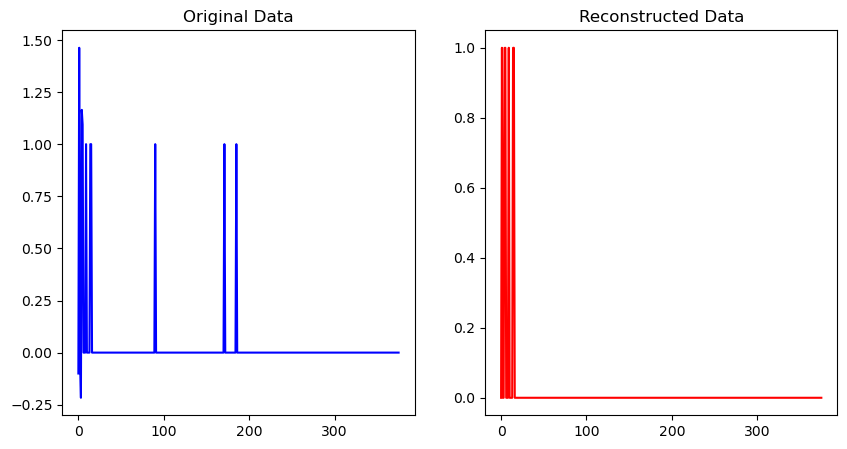

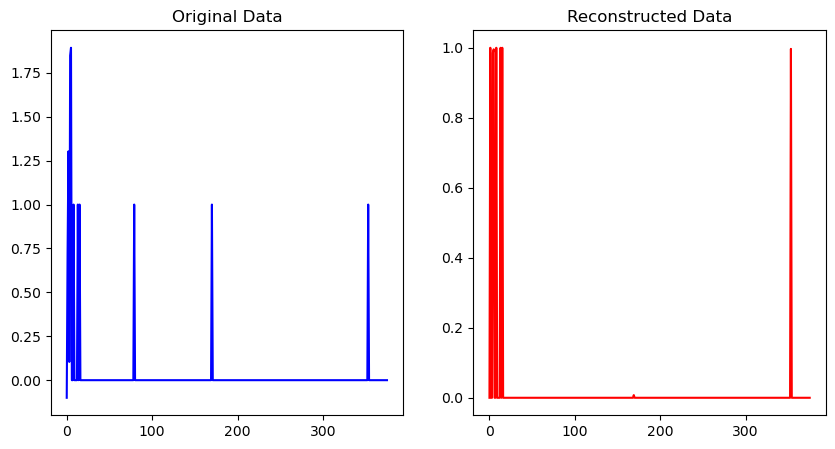

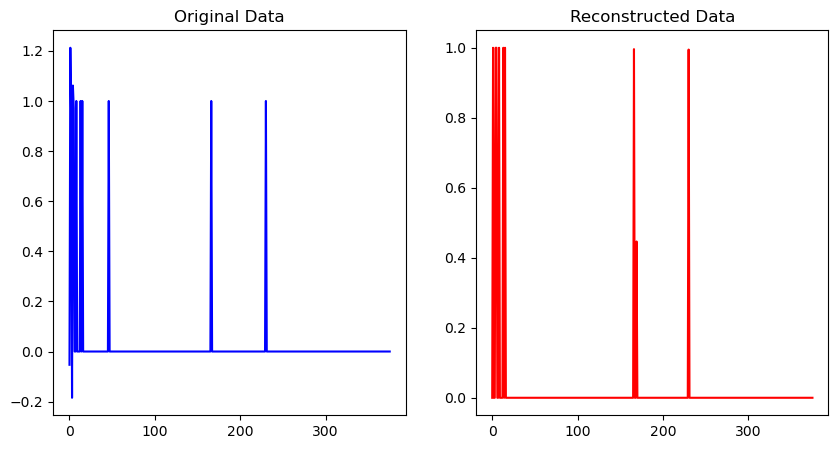

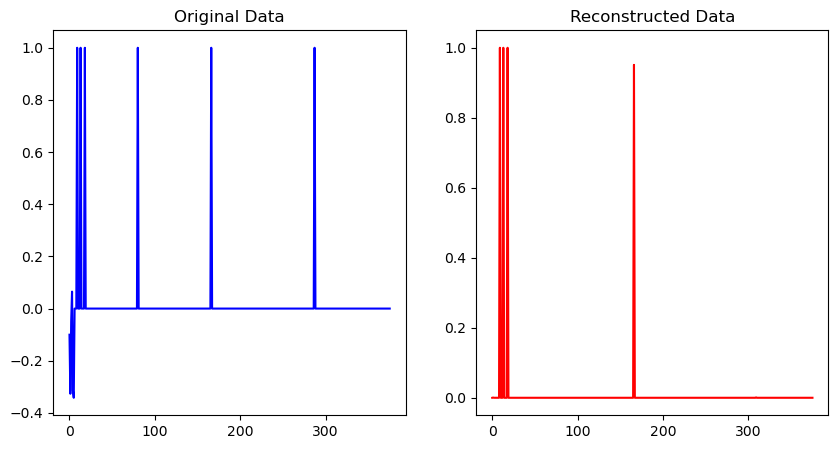

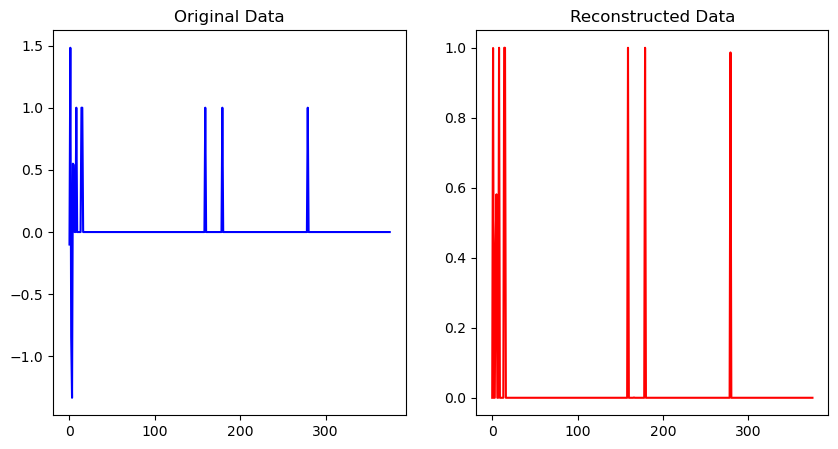

In [229]:
#this takes some randomly selected data points from the og data_dummies dataset, and their corresponding reconstructed data points generated by the autoencoder

indices_to_visualize = np.random.randint(0, len(data_dummies), size=5)

for i in indices_to_visualize: #go over the 5 indices from above
    original_data = data_dummies.iloc[i] #get og and reconstructed data of each index, reshape after so same format
    reconstructed_data_point = reconstructed_data[i]
    
    original_data = original_data.values.reshape((-1,))
    reconstructed_data_point = reconstructed_data_point.reshape((-1,))
    
    plt.subplot(1, 2, 1) #visualize the original data beside the autoencoded reconstucted data
    plt.title("Original Data")
    plt.plot(original_data, color='blue')
    
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data_point, color='red')
    
    plt.show()


In [242]:
#picking the threshold to be the 10th percentile of the anomaly reconstruction errors and classify a signal as anomaly if its reconstruction error is at least this much
threshold = np.percentile(reconstruction_errors, 10)

#mean_error = np.mean(reconstruction_errors)
#std_error = np.std(reconstruction_errors)
#threshold = mean_error + 0.1 * std_error 
# these thresholds to select anomalies are too broad, and takes like half the dataset

#here I extract the rows above the threshold to make a new dataframe of anomalous points
row_errors = np.mean(np.square(data_dummies.values - reconstructed_data), axis=1)
anomalous_indices3 = np.where(row_errors > threshold)[0] #get the row of the indices ^ 
anomalous_df3 = data_dummies.iloc[anomalous_indices3]

In [64]:
#combines info from anomalous points with the original dataset so that the columns arent scaled / are in their og form
anomalous_df3 = result_df.iloc[anomalous_indices3].merge(data_dummies.iloc[anomalous_indices3], left_index=True, right_index=True)
anom_names3 = anomalous_df3['name'].unique() #getting names from the anomalous dataset

## 4. Merging the results from clustering and autoencoder
Taking names that only exist as anomalies for both the clustering AND autoencoded detection results. And then filtering the original dataset for rows with only those names to get a dataset with anomaly-detected congress members only

In [65]:
common_elements = np.intersect1d(anom_names3, anom_names) 
print(f'names to investigate: \n { common_elements}')

#len(np.setdiff1d(anom_names2, anom_names3))#uncomment to see names in one dataset but not the other

names to investigate: 
 ['Alan S. Lowenthal' 'Andrew Garbarino' 'Ann Wagner' 'Anthony E. Gonzalez'
 'August Lee Pfluger' 'Billy Long' 'Blake Moore' 'Bob Gibbs' 'Brian Mast'
 'Carol Devine Miller' 'Charles J. "Chuck" Fleischmann' 'Chris Jacobs'
 'Cynthia Axne' 'Dean Phillips' 'Debbie Dingell' 'Deborah K. Ross'
 'Donald S. Beyer, Jr.' 'Dwight Evans' 'Elaine Luria'
 'Harold Dallas Rogers' 'James French Hill' 'James R. Langevin'
 'Josh Gottheimer' 'Katherine M. Clark' 'Kathy Castor' 'Kathy Manning'
 'Kevin Hern' 'Kurt Schrader' 'Lois Frankel' 'Marie Newman'
 'Marjorie Taylor Greene' 'Mark E. Green' 'Michael K. Simpson'
 'Mike Garcia' 'Nancy Pelosi' 'Patrick Fallon' 'Pete Sessions'
 'Peter Meijer' 'Richard W. Allen' 'Ro Khanna' 'Scott Franklin'
 'Scott H. Peters' 'Susie Lee' 'Suzan K. DelBene' 'Tom Malinowski'
 'Trey Hollingsworth' 'Victoria Spartz' 'Virginia Foxx'
 'William R. Keating']


In [66]:
result_df.columns

Index(['owner', 'ticker', 'asset_description', 'type', 'amount', 'party',
       'state', 'industry', 'sector', 'ptr_link', 'name', 'year',
       'upper_bound', 'SP500_Close', 'Volume', 'net',
       'transaction_unix_timestamp', 'disclosure_unix_timestamp'],
      dtype='object')

In [67]:
anomaly_result2 = result_df[result_df['name'].isin(common_elements) & (result_df['ticker'] != '--')][['name', 'party','ticker', 'amount', 'state', 'industry', 'sector', 'upper_bound', 'SP500_Close', 'Volume']].drop_duplicates(subset='name')
anomaly_result2

,name,party,ticker,amount,state,industry,sector,upper_bound,SP500_Close,Volume
17668,Tom Malinowski,Democrat,BLFSD,"$1,001 - $15,000",NJ,na,unknown,-0.100195,NaN,NaN
1638,Carol Devine Miller,Republican,MZOR,"$15,001 - $50,000",WV,na,unknown,-0.052942,-1.905445,-0.539481
2211,Cynthia Axne,Democrat,FB,"$1,001 - $15,000",IA,"Computer Software: Programming, Data Processing",Technology,-0.100195,-1.604629,-0.637638
7284,James R. Langevin,Democrat,BABA,"$50,001 - $100,000",RI,Business Services,Miscellaneous,0.014561,-1.244901,-1.329858
38,Alan S. Lowenthal,Democrat,LB,"$15,001 - $50,000",CA,Clothing/Shoe/Accessory Stores,Consumer Services,-0.052942,-1.135791,-0.687434
3596,"Donald S. Beyer, Jr.",Democrat,TDDXX,"$1,000,001 - $5,000,000",VA,na,unknown,6.629919,-1.077060,-1.225592
8368,Josh Gottheimer,Democrat,TSLA,"$1,001 - $15,000",NJ,Auto Manufacturing,Capital Goods,-0.100195,-0.916100,-1.368449
2898,Dean Phillips,Democrat,ETN,"$1,001 - $15,000",MN,Industrial Machinery/Components,Technology,-0.100195,-0.871676,-1.183740
11127,Kevin Hern,Republican,FSK,"$100,001 - $250,000",OK,na,unknown,0.217072,-0.873512,-0.868708
17992,Virginia Foxx,Republican,SO,"$1,001 - $15,000",NC,Electric Utilities: Central,Public Utilities,-0.100195,-0.835141,-1.097120


In [68]:
#making a new dataframe based on the marked anomalous names and indices
anomaly_result = result_df[result_df['name'].isin(common_elements)][['name', 'party','ticker', 'amount', 'state', 'industry', 'sector', 'net', 'SP500_Close', 'Volume', 'transaction_unix_timestamp', 'disclosure_unix_timestamp']].drop_duplicates(subset='name')

#convert unix timestamp back to datetime 
anomaly_result['transaction_datetime'] = pd.to_datetime(anomaly_result['transaction_unix_timestamp'], unit='s',  origin='unix', utc=True).dt.date
anomaly_result['disclosure_datetime'] = pd.to_datetime(anomaly_result['disclosure_unix_timestamp'], unit='s',  origin='unix', utc=True).dt.date
anomaly_result.drop(['transaction_unix_timestamp', 'disclosure_unix_timestamp'], axis=1, inplace=True)

anomaly_result

#the columns corresponding to the name dont neccessarily represent the anomalies

,name,party,ticker,amount,state,industry,sector,net,SP500_Close,Volume,transaction_datetime,disclosure_datetime
17668,Tom Malinowski,Democrat,BLFSD,"$1,001 - $15,000",NJ,na,unknown,0.068212,NaN,NaN,1969-12-31,1970-01-01
1638,Carol Devine Miller,Republican,MZOR,"$15,001 - $50,000",WV,na,unknown,0.061035,-1.905445,-0.539481,1969-12-31,1969-12-31
2211,Cynthia Axne,Democrat,FB,"$1,001 - $15,000",IA,"Computer Software: Programming, Data Processing",Technology,0.068212,-1.604629,-0.637638,1969-12-31,1970-01-01
7284,James R. Langevin,Democrat,BABA,"$50,001 - $100,000",RI,Business Services,Miscellaneous,0.055514,-1.244901,-1.329858,1969-12-31,1969-12-31
37,Alan S. Lowenthal,Democrat,--,"$15,001 - $50,000",CA,na,unknown,0.072077,-1.470082,-0.657526,1969-12-31,1970-01-01
10279,Katherine M. Clark,Democrat,--,"$1,001 - $15,000",MA,na,unknown,0.064900,-1.119004,-1.003198,1969-12-31,1969-12-31
3596,"Donald S. Beyer, Jr.",Democrat,TDDXX,"$1,000,001 - $5,000,000",VA,na,unknown,0.618643,-1.077060,-1.225592,1969-12-31,1969-12-31
8368,Josh Gottheimer,Democrat,TSLA,"$1,001 - $15,000",NJ,Auto Manufacturing,Capital Goods,0.064900,-0.916100,-1.368449,1969-12-31,1969-12-31
2903,Dean Phillips,Democrat,--,"$15,001 - $50,000",MN,na,unknown,0.062691,-0.871676,-1.183740,1969-12-31,1969-12-31
11123,Kevin Hern,Republican,--,"$1,001 - $15,000",OK,na,unknown,0.068212,-0.905863,-0.892417,1969-12-31,1969-12-31


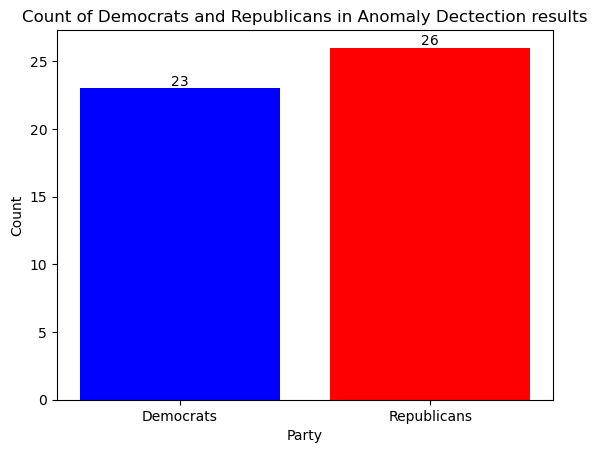

In [173]:
#bar graph dividing Democrats and Republicans based on the party col in the anomaly_result
democrats = len(anomaly_result[anomaly_result['party'] == 'Democrat'])
republicans = len(anomaly_result[anomaly_result['party'] == 'Republican'])
plt.bar(['Democrats', 'Republicans'], [democrats, republicans], color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Count of Democrats and Republicans in Anomaly Dectection results')
for i, count in enumerate([democrats, republicans]):
    plt.text(i, count, str(count), ha='center', va='bottom')

## 5. Visualizing Data 
By Reducing Dimensionality, we can better visualize the result of our data   

PCA reduces the dimensionality of the data by projecting it onto a lower-dimensional space while preserving the most important information. The direction of the axes (Principal Component 1 and Principal Component 2) represents the directions of maximum variance in the data. This reduction to two dimensions make it easier for visualization of clusters in scatter plots. And for autoencoders, outliers may show as data points that are distant from the majority of data points in the reduced-dimensional space.

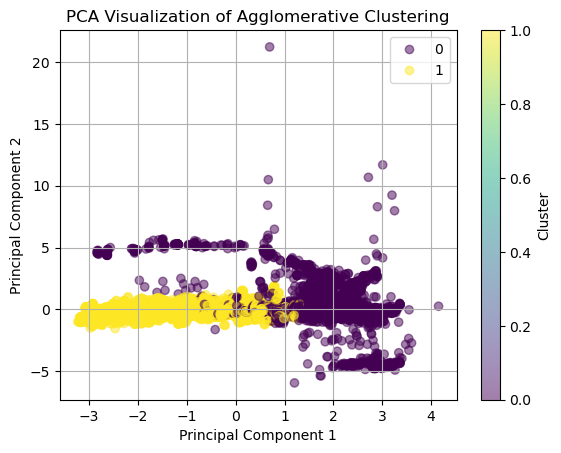

In [254]:
from sklearn.decomposition import PCA

#PCA with 2 components
pca = PCA(n_components=2)

#fit and transform to the reduced-dimensional space
reduced_data = pca.fit_transform(data_dummies)

scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Agglomerative Clustering')
plt.colorbar(scatter, label='Cluster')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, loc='upper right')
plt.grid(True)
plt.show()


##### Clustering model interpretation
Theres clear separation between the two clusters after the original dataset has been reduced to 2 dimensions
- there is some overlap (where the purple and yellow mix) which may mean the data is hard to separate into two distinct clusters
- the spread of data points within each cluster reflects the variability or dispersion of the data within that cluster, and we can see that the purple is much more dispersed than the yellow, indicating that the points in that cluster are not very similar
- important to note that this is a large dataset, so even with a low alpha, the size of the each cluster does not indicate how many datapoints are in each 

584/584 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step


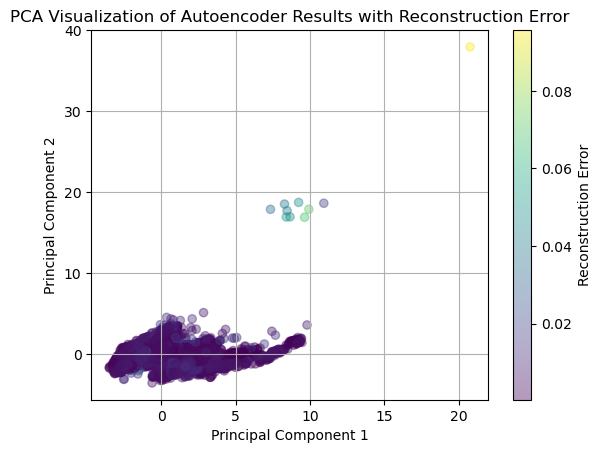

In [285]:
latent_space_representation = encoder.predict(data_dummies.values)

#PCA with 2 components
pca = PCA(n_components=2)

#fit and transform to the reduced-dimensional space
reduced_data_autoencoder = pca.fit_transform(latent_space_representation)

#show PCA visualization with reconstruction errors
plt.scatter(reduced_data_autoencoder[:, 0], reduced_data_autoencoder[:, 1], c=reconstruction_errors, cmap='viridis', alpha=0.4)
plt.colorbar(label='Reconstruction Error')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Autoencoder Results with Reconstruction Error')
plt.grid(True)
plt.show()

**PCA Autoencoder Reconstruction error Interpretation**
- it appears that most the datapoints are clustered and show a low error in its reconstruction, however, a few points show moderate errors and one shows a large error, these likely will be detected as anomalies
- in the main purple cluster, there are still some points (that dont display well) that had reconstruction errors although in the main cluster
- the code above compresses the data into 2 components, and plots it in a scatterplot, while the colors also show the reconstruction error


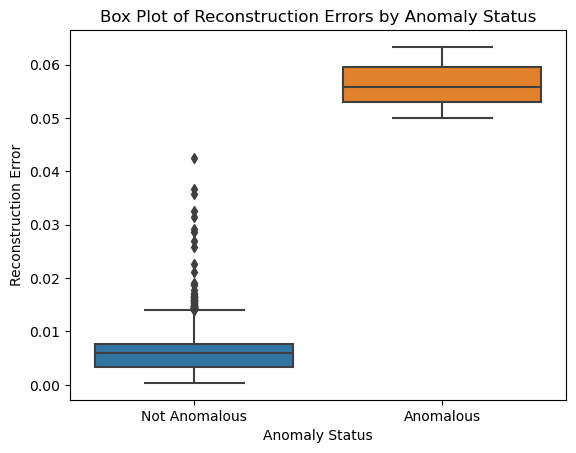

In [144]:
# making a box plot for the anomalous points vs non-anomalous points detected by the autoencoder
isanomalous = reconstruction_errors > threshold #anomaly status based on a threshold
status = np.where(isanomalous, 'Anomalous', 'Not Anomalous')

#df with reconstruction errors and anomaly status
error_df = pd.DataFrame({'Reconstruction Error': reconstruction_errors, 'Anomaly Status': status})

sns.boxplot(x='Anomaly Status', y='Reconstruction Error', data=error_df)
plt.title('Box Plot of Reconstruction Errors by Anomaly Status')
plt.xlabel('Anomaly Status')
plt.ylabel('Reconstruction Error')


Above is a box plot to visualize the maximum error over the reconstructed data with anomaly status as x-axis categories   

results: 
- more reconstruction errors for anomalous data points than for normal data points
- more outliers for non anomalous data points
- distribution of reconstruction errors for anomalous data has a higher variance than the distribution for normal data


#### Deriving Insights from Anomaly-only Dataset
I first get the max value of each congress member's 'net' - which is the highest amount the congress member has ever invested into the stock market, it is a good representative of how much money they have to invest and also how much they've earned from investing (as theyre reinvesting it)

In [182]:
#to get only the anomalous congress members, I include only the rows where the 'name' col matches names in the list of anomalous names aka common_elements
is_anomalous = data[data['name'].isin(common_elements)].groupby('name')[['party','net','ticker']].max().reset_index()
is_anomalous
#this shows how much anomalous congress members have invested in the market over the 3 years
# the ticker just corresponds to what the last invested which gave them that net amount, does not say they invested the most into that stock

,name,party,net,ticker
0,Alan S. Lowenthal,Democrat,302998,ZTS
1,Andrew Garbarino,Republican,30000,VMCXX
2,Ann Wagner,Republican,11350000,SYF
3,Anthony E. Gonzalez,Republican,200000,NKE
4,August Lee Pfluger,Republican,0,WFC
5,Billy Long,Republican,-50000,SO
6,Blake Moore,Republican,1585000,WYNN
7,Bob Gibbs,Republican,240000,XOM
8,Brian Mast,Republican,-35000,ZUO
9,Carol Devine Miller,Republican,1356001,YUMC


In [184]:
#the average 'net' in suspicious (anomalous) congress members
mean_is_anomalous = is_anomalous['net'].mean()

#now doing the same for non anomalous (law abiding) congress members

#a df where the names ARE NOT in list of names -- common_elements
not_anomalous = data[~data['name'].isin(common_elements)].groupby('name')[['party','net','ticker']].max().reset_index()
not_anomalous

#we can see that 49 congress members were marked as anomalous, while 148 were marked as non anomalous

,name,party,net,ticker
0,Abigail Spanberger,Democrat,45000,LHX
1,Ada Norah Henriquez,Democrat,-15000,OBMCX
2,Adam B. Schiff,Democrat,-50000,APPL
3,Adam Kinzinger,Republican,60000,USO
4,Adrian Smith,Republican,5000000,--
...,...,...,...,...
142,Vicente Gonzalez,Democrat,235000,TSLA
143,W. Gregory Steube,Democrat,140000,SNV
144,William R. Timmons,Democrat,45000,WMT
145,Wm. Lacy Clay,Democrat,-15000,PM


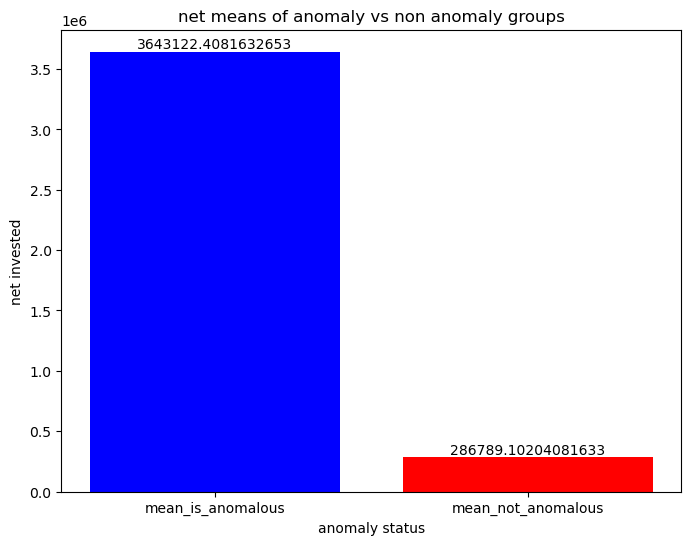

In [207]:
#the average 'net' in suspicious (anomalous) congress members
mean_not_anomalous = not_anomalous['net'].mean()

# bar plot of the means of each group (anom vs not anom)
plt.bar(['mean_is_anomalous', 'mean_not_anomalous'],[mean_is_anomalous, mean_not_anomalous], color=['blue', 'red'])
plt.xlabel('anomaly status')
plt.ylabel('net invested')
plt.title('net means of anomaly vs non anomaly groups')
#labels above bar
for i in range(len([mean_is_anomalous, mean_not_anomalous])):
    plt.text(i, [mean_is_anomalous, mean_not_anomalous][i], str([mean_is_anomalous, mean_not_anomalous][i]), ha='center', va='bottom')


Mean Net results
- We can see that anomalous congress members on average, invest 3,643,122 within 3 years, to have this much money means that either theyve been super successful investing or have insider information to make these funds.   
- While those that were not detected as anomalies have invested an average of $286,789, which can be expected from just regular investing, and having savings in the past to invest into the market. 


Next, I get the members from the anomaly group that have invested the most into the market

In [210]:
#getting the top earners from anomalous group
top_anomaly = is_anomalous.sort_values(by='net', ascending=False).head(20) 
top_anomaly

,name,party,net,ticker
34,Nancy Pelosi,Democrat,49550000,WORK
22,Josh Gottheimer,Democrat,45960000,Z
43,Suzan K. DelBene,Democrat,21880000,PLTR
31,Mark E. Green,Republican,12320000,XLM-USD
2,Ann Wagner,Republican,11350000,SYF
45,Trey Hollingsworth,Republican,8700000,ORCC
16,"Donald S. Beyer, Jr.",Democrat,5930000,VZ
47,Virginia Foxx,Republican,3365000,XOM
25,Kathy Manning,Democrat,3190000,WMT
41,Scott H. Peters,Democrat,3050000,RAND


''

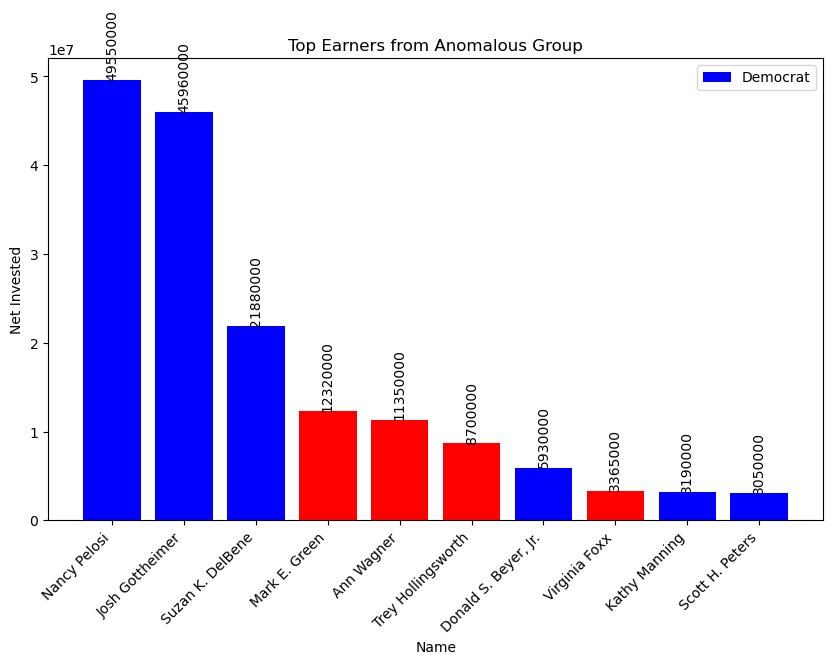

In [209]:
#bar chart showing the top investors from the anomalous group
party_colors = {'Republican': 'red', 'Democrat': 'blue'}
plt.figure(figsize=(10, 6))
plt.bar(top_anomaly['name'], top_anomaly['net'], color=top_anomaly['party'].map(party_colors))
plt.xlabel('Name')
plt.ylabel('Net Invested')
plt.title('Top investors from Anomalous Group')
plt.xticks(rotation=45, ha='right')
plt.legend(top_anomaly['party'])
for i, net_value in enumerate(top_anomaly['net']):
    plt.text(i, net_value, str(net_value), ha='center', va='bottom', rotation=90)
;

Here we can see the top anomalous congress members and an approximation of how much they've invested into the market (after buying and selling - their net total), the top 3 are democrats and they have all invested an absurdly high amount into the market.   

Surprisingly, looking at the entire dataset of non-anomalous and anomalous congress members, the top 10 net investors arent the same as the ones listed above, meaning the model is effective in identifying nuances that indicate anomalies. 

Lastly, I then look online in the news/media to look further into their investing habits, hopefully finding hints that explain this anomaly. 